In [1]:
from torch.utils.tensorboard import SummaryWriter

In [2]:
from __future__ import annotations
import os
import datetime
import numpy as np
import sklearn.metrics
import torch
from torch.utils.data import Dataset
import torchvision.transforms as T
from torch.utils.data import DataLoader, WeightedRandomSampler
import sklearn.datasets
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torchvision.models import resnet18


from tqdm.notebook import tqdm
import seaborn as sns

sns.set_style("dark")
sns.set(rc={"figure.figsize": (10, 10), "axes.grid": False})
rng = np.random.default_rng()

In [3]:
from torch.utils.data.dataloader import default_collate
from torchvision.transforms import v2

In [4]:
def unpickle(file):
    import pickle

    with open(file, "rb") as fo:
        dict = pickle.load(fo, encoding="bytes")
    return dict


In [47]:
label_description = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]

opposite = {1: 9, 9: 1, 3: 5, 5: 3, 4: 7, 7: 4}
opposite_multiplyers = torch.ones((10, 10))
for key, value in opposite.items():
    opposite_multiplyers[key][value] = 2

In [6]:
labels = []
data = []
for batch_ind in range(1, 6):
    batch = unpickle(f"./datasets/cifar10/data_batch_{batch_ind}")
    labels.extend(batch[b"labels"])
    if len(data) == 0:
        data = batch[b"data"].reshape(-1, 3, 32, 32)
    else:
        data = np.concatenate((data, batch[b"data"].reshape(-1, 3, 32, 32)))

# data = np.moveaxis(data, 1, -1)

In [7]:
def plot_grid(X, y, ncols=2, nrows=2, figsize=(10, 10), hide_axes=True):
    fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=figsize)
    indexes = rng.choice(np.arange(X.shape[0]), size=ax.shape)
    imgs = np.moveaxis(X[indexes].reshape(*ax.shape, 3, 32, 32), 2, -1)

    plt.imshow(imgs[0][0])
    labels = y[indexes].reshape(*ax.shape)
    for i in range(ax.shape[0]):
        for j in range(ax.shape[1]):
            ax[i, j].imshow(imgs[i, j], cmap='gray')
            ax[i, j].set_title(label_description[labels[i, j]])
            if hide_axes:
                ax[i, j].get_xaxis().set_visible(False)
                ax[i, j].get_yaxis().set_visible(False)

In [8]:
def plot_grid_and_label(
    dataloader,
    model,
    ncols=2,
    nrows=2,
    figsize=(10, 10),
    hide_axes=True,
    flatten_image=True,
    label_description=None,
):
    fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=figsize)

    batch = next(iter(dataloader))
    idx = rng.choice(np.arange(len(batch[0])), size=(nrows * ncols))

    imgs = batch[0][idx].to(device="cpu")
    labels = batch[1][idx].to(device="cpu")
    print(imgs.shape)
    pred = model(imgs).to(device="cpu")
    imgs, labels, pred = (
        torch.moveaxis(imgs, 1, -1).to(device="cpu").reshape(nrows, ncols, 32, 32, 3),
        labels.to(device="cpu").reshape(nrows, ncols, -1),
        pred.reshape(nrows, ncols, -1),
    )

    for i in range(ax.shape[0]):
        for j in range(ax.shape[1]):
            ax[i, j].imshow(imgs[i, j], cmap="gray")
            ax[i, j].set_title(
                f"label: {label_description[labels[i, j].argmax()]}, prediction: {label_description[pred[i, j].argmax()]}"
            )
            if hide_axes:
                ax[i, j].get_xaxis().set_visible(False)
                ax[i, j].get_yaxis().set_visible(False)

In [9]:
X, y = data, np.array(labels)
X = X / 255
X, y = X.astype(dtype=np.float32), y
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [10]:
counts = { j: np.sum(y_train == i) for i, j in enumerate(label_description) }

In [11]:
counts # what to do with imbalanced classes?

{'airplane': 3807,
 'automobile': 3740,
 'bird': 3741,
 'cat': 3742,
 'deer': 3837,
 'dog': 3710,
 'frog': 3720,
 'horse': 3759,
 'ship': 3725,
 'truck': 3719}

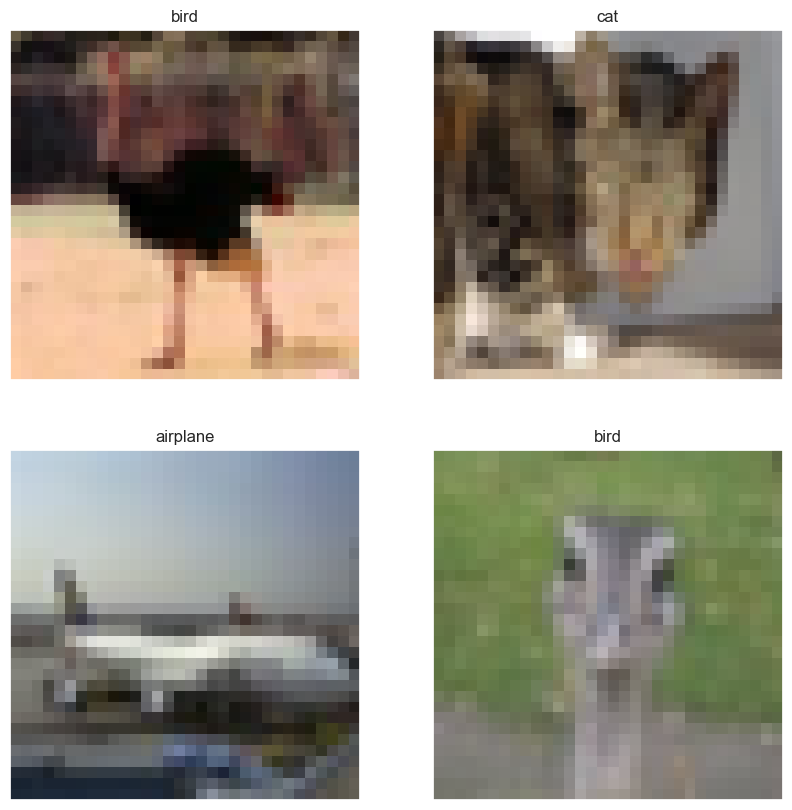

In [12]:
plot_grid(X_train, y_train)

## Torch utils

In [13]:
def get_n_params(model):
    pp = 0
    for p in list(model.parameters()):
        nn = 1
        for s in list(p.size()):
            nn = nn * s
        pp += nn
    return pp

tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 2., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 2., 1., 1.]])

In [67]:
class ImageDataset(Dataset):
    inds = torch.arange(10, device="cuda")

    def __init__(
        self,
        images,
        targets,
        transform=None,
        target_transform=None,
        train_transform=None,
    ):
        self.images = images
        self.targets = (ImageDataset.inds[None] == targets[:, None]).to(
            dtype=torch.float32
        )
        # self.custom_loss = opposite_multiplyers[self.targets.detach().cpu().numpy()]
        self.transform = transform
        self.target_transform = target_transform
        self.train_transform = train_transform

        self.is_train = True

    def train(self):
        self.is_train = True

    def eval(self):
        self.is_train = False

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.targets[idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)

        if self.train_transform and self.is_train:
            image = self.train_transform(image)
        return image, label

In [68]:
def accuracy_func(pred, tareget):
    return (pred.argmax(dim=-1) == tareget.argmax(dim=-1)).sum() / len(tareget)


def train_one_epoch(
    model: torch.nn.Module,
    loss_fn,
    epoch_index,
    training_loader,
    testing_loader,
    optimizer,
    writer: SummaryWriter,
    model_name,
    smalest_test_loss=np.inf,
    sced=None,
):
    running_loss = 0.0
    running_acc = 0.0
    last_loss = 0.0

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    with tqdm(training_loader) as iterator:
        for i, data in enumerate(iterator):
            model.train(True)
            # Every data instance is an input + label pair
            inputs, labels = data

            # Zero your gradients for every batch!
            optimizer.zero_grad()

            # Make predictions for this batch
            outputs = model(inputs)

            # Compute the loss and its gradients
            loss = loss_fn(outputs, labels)
            loss.backward()

            # Adjust learning weights
            optimizer.step()
            if sced:
                sced.step()

            # Gather data and report
            running_loss += loss
            running_acc += accuracy_func(outputs, labels)
            if i % 200 == 199:
                running_loss_test = 0
                running_acc_test = 0

                last_loss = running_loss / 200  # loss per batch
                tb_x = epoch_index * len(training_loader) + i + 1

                iterator.set_description_str(str(running_acc / 200))
                writer.add_scalars(
                    "accuracy",
                    {
                        "train": running_acc / 200,
                    },
                    tb_x,
                )
                writer.add_scalars(
                    "loss",
                    {
                        "train": running_loss / 200,
                    },
                    tb_x,
                )
                running_loss = 0.0
                running_acc = 0.0
        del loss
        torch.cuda.empty_cache()
    return last_loss, smalest_test_loss

## Images
Use Conv2D layers with Dense layer on top

In [69]:
transforms = v2.Compose(
    [
        v2.ColorJitter(
            brightness=0.2,
            saturation=0.2,
            hue=0.2,
        ),
        v2.RandomHorizontalFlip(),
    ]
)

In [70]:
# create train and validation datasets, these datasets should use 28x28x1 images

# create train and validation datasets, these datasets should use flattened images
train_ds = ImageDataset(
    torch.tensor(X_train).to(device="cuda"),
    torch.tensor(y_train).to(device="cuda"),
    transform=v2.ToTensor(),
    train_transform=transforms,
)

test_ds = ImageDataset(
    torch.tensor(X_test).to(device="cuda"),
    torch.tensor(y_test).to(device="cuda"),
    transform=v2.ToTensor(),
)

In [18]:
train_dl = DataLoader(
    train_ds,
    batch_size=128,
    shuffle=True
)

test_dl = DataLoader(
    test_ds,
    shuffle=True,
    batch_size=128,
)

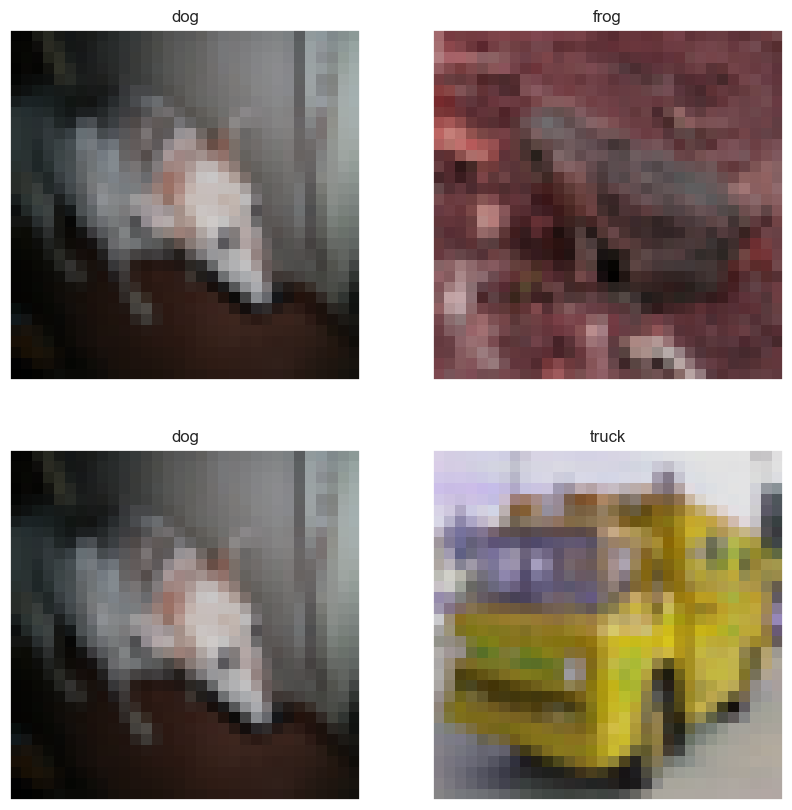

In [19]:
dx, dy = next(iter(train_dl))
plot_grid(dx.cpu().detach().numpy(), dy.argmax(dim=-1).cpu().detach().numpy())


In [20]:
# 50k model
class ConvModel(torch.nn.Module):
    def __init__(self, device="cpu"):
        super(ConvModel, self).__init__()

        self.conv: torch.nn.Sequential = torch.nn.Sequential(
            #
            torch.nn.Conv2d(3, 16, 3, padding=1),
            torch.nn.BatchNorm2d(16),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(16, 16, 3, padding=1),
            torch.nn.BatchNorm2d(16),
            torch.nn.LeakyReLU(),
            #
            torch.nn.MaxPool2d(2),
            #
            torch.nn.Conv2d(16, 32, 3, padding=1),
            torch.nn.BatchNorm2d(32),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(32, 32, 3, padding=1),
            torch.nn.BatchNorm2d(32),
            torch.nn.LeakyReLU(),
            #
            torch.nn.MaxPool2d(2),
            #
            torch.nn.Conv2d(32, 32, 3, padding=1),
            torch.nn.BatchNorm2d(32),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(32, 32, 3, padding=1),
            torch.nn.BatchNorm2d(32),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(32, 32, 3, padding=1),
            torch.nn.BatchNorm2d(32),
            torch.nn.LeakyReLU(),
            #
            torch.nn.MaxPool2d(2),
            #
            torch.nn.Conv2d(32, 16, 3, padding=1),
            torch.nn.BatchNorm2d(16),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(16, 16, 3, padding=1),
            torch.nn.BatchNorm2d(16),
            torch.nn.LeakyReLU(),
            #
            torch.nn.MaxPool2d(2),
        )

        self.fc = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(64, 32),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(32, 16),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(16, 10),
            torch.nn.Softmax(dim=-1),
        )

    def forward(self, x):
        x = self.conv(x)
        return self.fc(x)


model = ConvModel(device="cuda").to(device="cuda")


model(next(iter(train_dl))[0]).shape

logdir = os.path.join(
    "logs/cifar10/large_conv", datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
)
writer = SummaryWriter(log_dir=logdir)
writer.add_graph(model, next(iter(train_dl))[0])

In [21]:
## Large model
# class ConvModel(torch.nn.Module):
#     def __init__(self, device="cpu"):
#         super(ConvModel, self).__init__()

#         self.conv: torch.nn.Sequential = torch.nn.Sequential(
#             #
#             torch.nn.Conv2d(3, 16, 3, padding=1),
#             torch.nn.BatchNorm2d(16),
#             torch.nn.LeakyReLU(),
#             torch.nn.Conv2d(16, 16, 3, padding=1),
#             torch.nn.BatchNorm2d(16),
#             torch.nn.LeakyReLU(),
#             #
#             torch.nn.MaxPool2d(2),
#             #
#             torch.nn.Conv2d(16, 32, 3, padding=1),
#             torch.nn.BatchNorm2d(32),
#             torch.nn.LeakyReLU(),
#             torch.nn.Conv2d(32, 32, 3, padding=1),
#             torch.nn.BatchNorm2d(32),
#             torch.nn.LeakyReLU(),
#             #
#             torch.nn.MaxPool2d(2),
#             #
#             torch.nn.Conv2d(32, 32, 3, padding=1),
#             torch.nn.BatchNorm2d(32),
#             torch.nn.LeakyReLU(),
#             torch.nn.Conv2d(32, 32, 3, padding=1),
#             torch.nn.BatchNorm2d(32),
#             torch.nn.LeakyReLU(),
#             torch.nn.Conv2d(32, 32, 3, padding=1),
#             torch.nn.BatchNorm2d(32),
#             torch.nn.LeakyReLU(),
#             #
#             torch.nn.MaxPool2d(2),
#             #
#             torch.nn.Conv2d(32, 16, 3, padding=1),
#             torch.nn.BatchNorm2d(16),
#             torch.nn.LeakyReLU(),
#             torch.nn.Conv2d(16, 16, 3, padding=1),
#             torch.nn.BatchNorm2d(16),
#             torch.nn.LeakyReLU(),
#             #
#             torch.nn.MaxPool2d(2),
#         )

#         self.fc = torch.nn.Sequential(
#             torch.nn.Flatten(),
#             torch.nn.Linear(64, 32),
#             torch.nn.LeakyReLU(),
#             torch.nn.Linear(32, 16),
#             torch.nn.LeakyReLU(),
#             torch.nn.Linear(16, 10),
#             torch.nn.Softmax(dim=-1),
#         )

#     def forward(self, x):
#         x = self.conv(x)
#         return self.fc(x)


# model = ConvModel(device="cuda").to(device="cuda")

# model(next(iter(train_dl))[0]).shape

# logdir = os.path.join(
#     "logs/cifar10/large_conv", datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# )
# writer = SummaryWriter(log_dir=logdir)
# writer.add_graph(model, next(iter(train_dl))[0])


In [22]:
# compile the model, make sure to add accuracy metric
loss = torch.nn.CrossEntropyLoss()
optim = torch.optim.Adam(list(model.parameters()))
# sced = torch.optim.lr_scheduler.LinearLR(optim, 0.005, 0.00001,total_iters=5000)

In [23]:
x, y = next(iter(train_dl))

In [24]:
pred = model(x)

In [25]:
params = list(model.parameters())

In [26]:
get_n_params(model)

54570

In [27]:
min_test = np.inf
writer.add_scalar(
    "params count",
    get_n_params(model),
    0,
)
for i in tqdm(range(20)):
    
    model.train(True)
    loss_val, min_test = train_one_epoch(
        model.to(device="cuda"),
        loss,
        i,
        train_dl,
        test_dl,
        optim,
        writer,
        "ConvModel",
        min_test,
        # sced=sced,
    )

    model.eval()

    running_loss = 0.0
    running_acc = 0.0
    with torch.no_grad():
        for data, label in test_dl:
            pred = model(data)
            running_loss += loss(pred, label).detach()
            running_acc += accuracy_func(pred, label)
        writer.add_scalars(
            "loss",
            {
                "test": running_loss / len(test_dl),
            },
            len(train_dl) * (i + 1),
        )
        writer.add_scalars(
            "accuracy",
            {
                "test": running_acc / len(test_dl),
            },
            len(train_dl) * (i + 1),
        )


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/293 [00:00<?, ?it/s]

  0%|          | 0/293 [00:00<?, ?it/s]

  0%|          | 0/293 [00:00<?, ?it/s]

  0%|          | 0/293 [00:00<?, ?it/s]

  0%|          | 0/293 [00:00<?, ?it/s]

  0%|          | 0/293 [00:00<?, ?it/s]

  0%|          | 0/293 [00:00<?, ?it/s]

  0%|          | 0/293 [00:00<?, ?it/s]

  0%|          | 0/293 [00:00<?, ?it/s]

  0%|          | 0/293 [00:00<?, ?it/s]

  0%|          | 0/293 [00:00<?, ?it/s]

  0%|          | 0/293 [00:00<?, ?it/s]

  0%|          | 0/293 [00:00<?, ?it/s]

  0%|          | 0/293 [00:00<?, ?it/s]

  0%|          | 0/293 [00:00<?, ?it/s]

  0%|          | 0/293 [00:00<?, ?it/s]

  0%|          | 0/293 [00:00<?, ?it/s]

  0%|          | 0/293 [00:00<?, ?it/s]

  0%|          | 0/293 [00:00<?, ?it/s]

  0%|          | 0/293 [00:00<?, ?it/s]

torch.Size([4, 3, 32, 32])


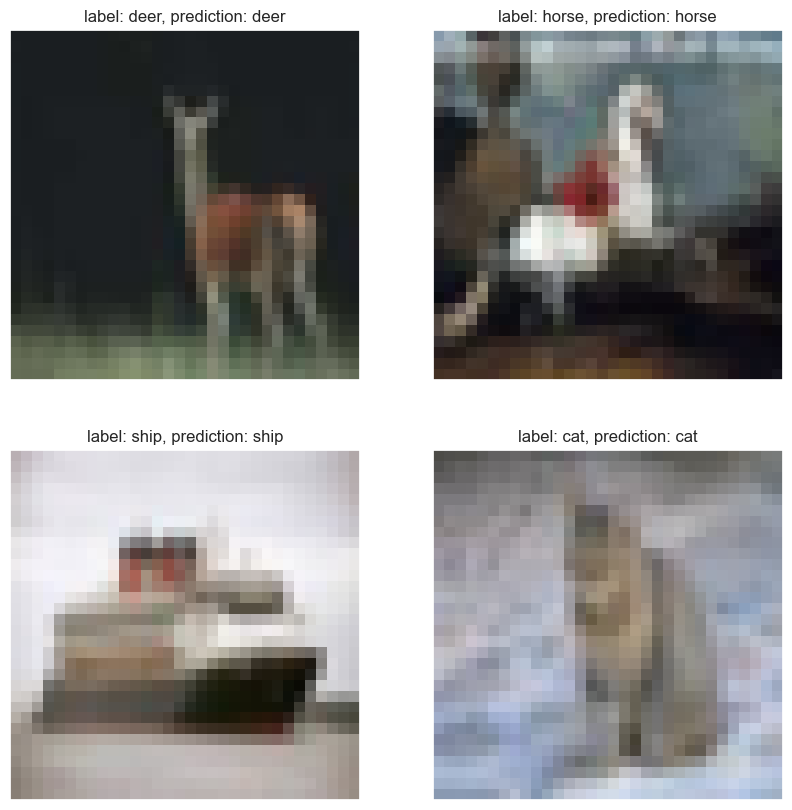

In [28]:
plot_grid_and_label(test_dl, model.to(device='cpu'), label_description=label_description)

In [29]:
len(X_test)

12500

In [35]:
model = model.eval()

In [36]:
with torch.no_grad():
    y_pred = (
        (
            model.to(device="cpu")(
                torch.tensor(X_test)
                .reshape(-1, 3, 32, 32)
                .to(device="cpu", dtype=torch.float32)
            )
            .detach()
            .numpy()
        ).argmax(axis=-1)
    )


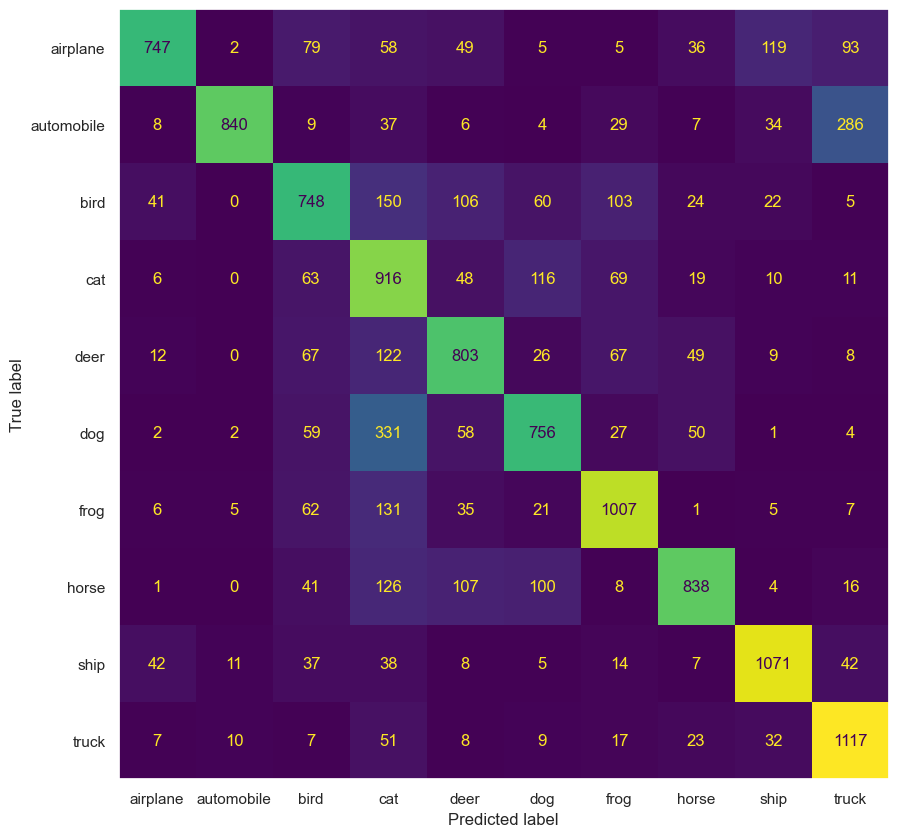

In [37]:
_, ax = plt.subplots(figsize=(10, 10))
sklearn.metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=label_description, ax=ax, colorbar=False)

##### Balanced accuracy

In [38]:
accuracy = y_test == y_pred
accuracy.sum()/len(y_test), np.mean([np.mean(accuracy[y_test == i]) for i in range(10)])

(0.70744, 0.7065539331849066)

In [39]:
writer.close()